In [ ]:
image.load_img()
get_fdata()
calculate median image in nilearn per subject per task
calculate median image for task

## calculate tSNR maps from fmriprep BOLD

In [ ]:
import os
import nibabel as nib
import numpy as np
from nilearn.image import concat_imgs, mean_img
from nilearn.image.image import _crop_img_to as crop_img_to

# Define the directory where tSNR maps are located
tsnr_dir = '/dartfs-hpc/scratch/f0042x1/tsnr/'

# Define the list of tasks
tasks = ["alignvideo", "faces", "shortvideo", "social", "fractional", "narratives"]

# Initialize a dictionary to store group median maps for each task
group_median_maps = {}

# Loop through each task
for task in tasks:
    task_maps = []
    
    # Loop through each participant
    for participant_dir in os.listdir(tsnr_dir):
        participant_path = os.path.join(tsnr_dir, participant_dir)
        tsnr_files = os.listdir(participant_path)
        
        # TODO: only glob the ones that have _tsnr in the filename
        # Filter tSNR files for the current task
        task_files = [file for file in tsnr_files if task in file]
        tsnr_files = [file for file in task_files if "bold_tsnr" in file]

        # Check if there are tSNR files for the current task
        if len(tsnr_files) > 0:
            # Load tSNR maps for the current task
            tsnr_maps = [nib.load(os.path.join(participant_path, file)) for file in tsnr_files]
            
            # Concatenate tSNR maps for the current participant and task
            concatenated_maps = concat_imgs(tsnr_maps)
            
            # Calculate the median tSNR map for the current participant and task
            median_map = np.median(concatenated_maps.get_data(), axis=-1)
            
            # Create a Nifti image for the median map
            median_img_obj = nib.Nifti1Image(median_map, concatenated_maps.affine)
            
            # Store the median map in the task_maps list
            task_maps.append(median_img_obj)
    
    # Concatenate median maps across participants for the current task
    if task_maps:
        # task_median_img = mean_img(task_maps)
        task_stacked = concat_imgs(task_maps)
        # TRY: Calculate the median across the last dimension
        median_data = np.median(task_stacked.get_fdata(), axis=-1)
        median_nifti = nib.Nifti1Image(median_data, task_stacked.affine)

        
        # Store the group median map for the current task
        group_median_maps[task] = median_nifti

        # Save the group median maps to files (optional)
        output_dir = '/dartfs-hpc/scratch/f0042x1/tsnr_median'  # Specify the output directory
        output_file = os.path.join(output_dir, f"group_median_tsnr_{task}.nii.gz")
        median_nifti.to_filename(output_file)

# Access group median maps for each task using group_median_maps dictionary
for task, median_img in group_median_maps.items():
    print(f"Task: {task}")
    print(f"Group Median Image: {median_img}")

# You can access the group median maps for each task using the group_median_maps dictionary.
# Optionally, you can save the group median maps to files.


In [ ]:
cp * /dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep_qc/tsnr

## calculate median value of tSNR maps per subject/task

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import glob
import os, re

# Base path where participant folders are located
base_path = '/dartfs-hpc/scratch/f0042x1/tsnr'
# gray_matter_mask = 
# Helper function to extract metadata from filename
def extract_metadata(filename):
    """
    Extracts metadata from the given filename.

    Parameters:
    filename (str): The filename to extract metadata from.

    Returns:
    dict: A dictionary containing extracted metadata.
    """

    # Extract the base name of the file (without the full path)
    base_name = os.path.basename(filename)

    # Define the regular expression pattern
    pattern = r'sub-(?P<sub>\w+)_ses-(?P<ses>\w+)_task-(?P<task>\w+)_acq-\w+_run-(?P<run>\w+)_space-\w+_desc-\w+_bold_tsnr.nii.gz'

    # Match the pattern with the filename
    match = re.match(pattern, base_name)

    if match:
        # Extract metadata from the matched groups
        return match.groupdict()
    else:
        # If the pattern does not match, return an empty dictionary or handle it as needed
        return {}


# Helper function to load image and apply mask
def apply_mask(image_path):
    from nilearn import datasets, plotting, masking, image
    from nilearn.input_data import NiftiMasker
    # Load image, apply mask, and return the masked image
    mni_brain_mask = datasets.load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mni_brain_mask)
    nifti = image.load_img(image_path) 
    # data = nifti.get_fdata()
    # data[data == 0] = np.nan  # Replace 0 with NaN
    # stat_map_img = nib.Nifti1Image(data, affine=nifti.affine)

    masked_map = masker.fit_transform(nifti)
    # masked_stat_map_img = masker.inverse_transform(masked_stat_map)
    return masked_map

# Initialize DataFrame
columns = ['sub', 'ses',  'task', 'run', 'median_value', 'filename']
df = pd.DataFrame(columns=columns)

# Iterate over participant folders
for sub_folder in glob.glob(os.path.join(base_path, 'sub-*')):
    for tsnr_file in glob.glob(os.path.join(sub_folder, '*_tsnr.nii.gz')):
        metadata = extract_metadata(tsnr_file)

        # Load tSNR image and apply gray matter mask
        masked_image = apply_mask(tsnr_file)
        median_value = np.median(masked_image)

        # Append to DataFrame
        df = df.append({**metadata, 'median_value': median_value, 'filename': tsnr_file}, ignore_index=True)

# Save DataFrame to CSV
df.to_csv('/dartfs-hpc/rc/lab/C/CANlab/labdata/data/spacetop_data/derivatives/fmriprep_qc/tsnr/tsnr_persub.csv', index=False)


## plot tsnr maps

In [1]:
import sys
list = sys.path
print(list)


['/Users/h/Documents/projects_local/spacetop-prep/spacetop_prep/qcplot/iqmvalues', '/Users/h/miniconda3/envs/spacetop/lib/python311.zip', '/Users/h/miniconda3/envs/spacetop/lib/python3.11', '/Users/h/miniconda3/envs/spacetop/lib/python3.11/lib-dynload', '', '/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages']


In [3]:
import os, glob
from os.path import join
import pandas as pd
import neuromaps
from nilearn import image
import numpy as np
from surfplot import Plot
import nibabel as nib
from scipy import stats
from neuromaps.datasets import fetch_fslr, fetch_fsaverage

In [4]:
from neuromaps.datasets import fetch_atlas

## plot 

In [66]:
def t2zmap(t_nii, df):
    t_map_data = t_nii.get_fdata()
    # Convert t-values to z-values
    z_map_data = stats.norm.ppf(stats.t.cdf(t_map_data, df))
    # Create a new Nifti image for the z-map
    z_map_nifti = image.new_img_like(t_nii, z_map_data)
    return z_map_nifti


def plot_roi(roi_name, lh_labels, rh_labels, roi_dict, surfaces):
    # roi_name = "TPJ"
    lh, rh = surfaces
    p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], mirror_views=True)
    # fig = p.build()
    lh_roi_map = np.full(lh_labels.shape, np.nan)
    lh_roi_map[np.in1d(lh_labels, roi_dict[roi_name])] = 1

    rh_roi_map = np.full(rh_labels.shape, np.nan)
    rh_roi_map[np.in1d(rh_labels, roi_dict[roi_name])] = 1
    # plot_roi(lh_roi_map, rh_roi_map, roi_name, 'Reds')
    p.add_layer({'left': lh_roi_map, 'right': rh_roi_map}, cmap='YlOrRd_r', cbar=False)
    fig = p.build()
    fig.show()



def process_medial_wall(data_path, nifti_dir, fslr_density='32k', data_dir='/tmp'):
    """
    Masks out the medial wall from the provided data.

    Parameters:
    - data_path: Path to the data file.
    - nifti_dir: Directory containing the spm data.
    - fslr_density: Density of the fslr data (default is '32k').
    - data_dir: Directory to fetch the fslr data (default is '/tmp').

    Returns:
    - stimP_lh: Left hemisphere data with medial wall masked out.
    - stimP_rh: Right hemisphere data with medial wall masked out.
    """
    
    nifti2fslr = neuromaps.transforms.mni152_to_fslr(
        join(nifti_dir, data_path),
        fslr_density=fslr_density, 
        method='linear'
    )
    
    fslr = neuromaps.datasets.fetch_fslr(density=fslr_density, data_dir=data_dir)
    
    nifti2fslr_lh = nifti2fslr[0].darrays[0].data
    nifti2fslr_rh = nifti2fslr[1].darrays[0].data
    
    fslr_medial_L = nib.load(fslr['medial'][0])
    fslr_medial_R = nib.load(fslr['medial'][1])
    
    medial_indexL = np.where(fslr_medial_L.darrays[0].data == 0)[0]
    medial_indexR = np.where(fslr_medial_R.darrays[0].data == 0)[0]
    
    nifti2fslr_lh[medial_indexL] = np.nan
    nifti2fslr_rh[medial_indexR] = np.nan
    
    return nifti2fslr_lh, nifti2fslr_rh


def t2zmap(t_nii, df):
    t_map_data = t_nii.get_fdata()
    # Convert t-values to z-values
    z_map_data = stats.norm.ppf(stats.t.cdf(t_map_data, df))
    # Create a new Nifti image for the z-map
    z_map_nifti = image.new_img_like(t_nii, z_map_data)
    return z_map_nifti

def plot_fslr(leftmap, rightmap, 
              density='32k', views=['lateral', 'medial', 'ventral'], 
              surface_type='inflated', cmap_key='plasma', cmap_range=(0,70), cbar_label='insert_task_label'):
    surfaces = neuromaps.datasets.fetch_fslr(density=density, data_dir='/tmp')
    lh, rh = surfaces[surface_type]

    p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=views, mirror_views=True)
    p._add_colorbars()
    p.add_layer({'left': leftmap, 
                'right': rightmap}, cmap=cmap_key, color_range=cmap_range, cbar_label=cbar_label) # cbar=False, 
    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=0)
    fig = p.build(cbar_kws=cbar_kws)
    fig.show()


## median values of tsnr map

In [114]:
def apply_mask(image_path):
    from nilearn import datasets, plotting, masking, image
    from nilearn.input_data import NiftiMasker
    # Load image, apply mask, and return the masked image
    mni_brain_mask = datasets.load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mni_brain_mask)
    nifti = image.load_img(image_path) 
    # data = nifti.get_fdata()
    # data[data == 0] = np.nan  # Replace 0 with NaN
    # stat_map_img = nib.Nifti1Image(data, affine=nifti.affine)

    masked_map = masker.fit_transform(nifti)
    # masked_stat_map_img = masker.inverse_transform(masked_stat_map)
    return masked_map.ravel() # adds another dimension (1, #voxels), thereby we need to iron out the first dimension


In [117]:
masked_map.ravel()

array([24.03811 , 25.601889, 27.084316, ..., 23.400028, 24.12357 ,
       25.155602], dtype=float32)

In [119]:
# svnii = image.load_img(join(tsnr_dir,'group_median_tsnr_alignvideo.nii.gz'))
print(f"individual {np.median(apply_mask(join(tsnr_dir,'sub-0047_ses-01_task-alignvideo_acq-mb8_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_tsnr.nii.gz')))}")
print(f"alignvideo {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_alignvideo.nii.gz')))}")
print(f"narratives {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_narratives.nii.gz')))}")
print(f"social {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_social.nii.gz')))}")
print(f"faces {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_faces.nii.gz')))}")
print(f"fractional {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_fractional.nii.gz')))}")
print(f"shortvideo {np.median(apply_mask(join(tsnr_dir,'group_median_tsnr_shortvideo.nii.gz')))}")
videodata = apply_mask(join(tsnr_dir,'group_median_tsnr_alignvideo.nii.gz'))
np.min(videodata)
np.max(videodata)

nardata = apply_mask(join(tsnr_dir,'group_median_tsnr_narratives.nii.gz'))
print(f"narratives: {np.min(nardata)}")
print(f"narratives max: {np.max(nardata)}")



/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


individual 66.78800964355469


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


alignvideo 50.489620208740234


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


narratives 52.313438415527344


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


social 52.24527359008789


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


faces 51.77565002441406


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


fractional 51.518856048583984


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


shortvideo 52.24527359008789


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


narratives: 4.301497459411621
narratives max: 101.21871185302734


In [95]:
videodata.shape

(1, 1882989)

## plot tsnr
I'll first plot the TSNR maps per task, in fsaverage surface maps

In [82]:
tsnr_dir = '/Volumes/fmriprep_qc/tsnr'
alignvideo_fname = join(tsnr_dir,'group_median_tsnr_alignvideo.nii.gz')
alignvideo = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_alignvideo.nii.gz'), fslr_density='32k', method='linear')
narratives = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_narratives.nii.gz'), fslr_density='32k', method='linear')
social = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_social.nii.gz'), fslr_density='32k', method='linear')
faces = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_faces.nii.gz'), fslr_density='32k', method='linear')
fractional = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_fractional.nii.gz'), fslr_density='32k', method='linear')
shortvideo = neuromaps.transforms.mni152_to_fslr(join(tsnr_dir,'group_median_tsnr_shortvideo.nii.gz'), fslr_density='32k', method='linear')

In [83]:
alignvideo_lh_nonmedial, alignvideo_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_alignvideo.nii.gz',
    nifti_dir=tsnr_dir
)

narratives_lh_nonmedial, narratives_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_narratives.nii.gz',
    nifti_dir=tsnr_dir
)

social_lh_nonmedial, social_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_social.nii.gz',
    nifti_dir=tsnr_dir
)

faces_lh_nonmedial, faces_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_faces.nii.gz',
    nifti_dir=tsnr_dir
)

fractional_lh_nonmedial, fractional_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_fractional.nii.gz',
    nifti_dir=tsnr_dir
)

shortvideo_lh_nonmedial, shortvideo_rh_nonmedial = process_medial_wall(
    data_path='group_median_tsnr_shortvideo.nii.gz',
    nifti_dir=tsnr_dir
)

ind_lh_nonmedial, ind_rh_nonmedial = process_medial_wall(
    data_path='sub-0047_ses-01_task-alignvideo_acq-mb8_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_tsnr.nii.gz',
    nifti_dir=tsnr_dir
)

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/2361140882.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


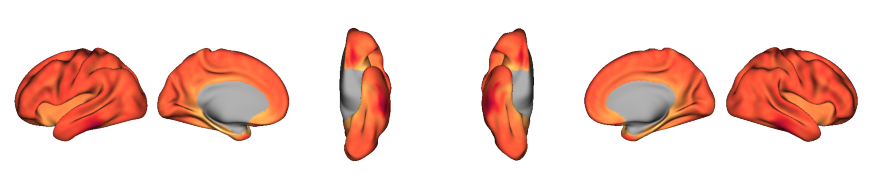

In [28]:
# surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
# lh, rh = surfaces['inflated']

# p = Plot(surf_lh=lh, surf_rh=rh, size=(1000, 200), zoom=1.2, layout='row', views=['lateral', 'medial', 'ventral'], mirror_views=True)
# p.add_layer({'left': alignvideo_lh_nonmedial, 
#              'right': alignvideo_rh_nonmedial}, 
#              cmap='YlOrRd_r', cbar=False)
# p._add_colorbars(location='bottom')
# fig = p.build()
# fig.show()


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_7908/1431239625.py:85: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

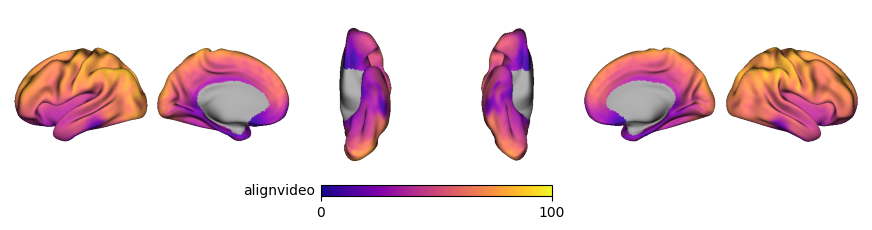

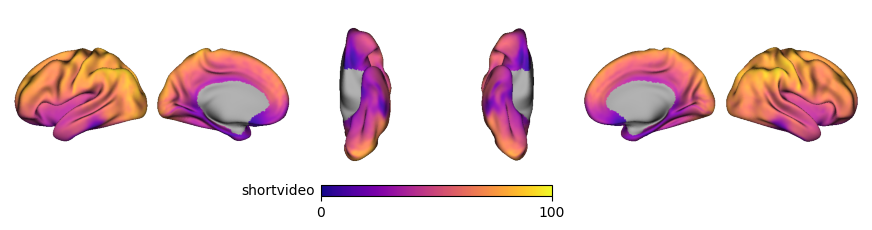

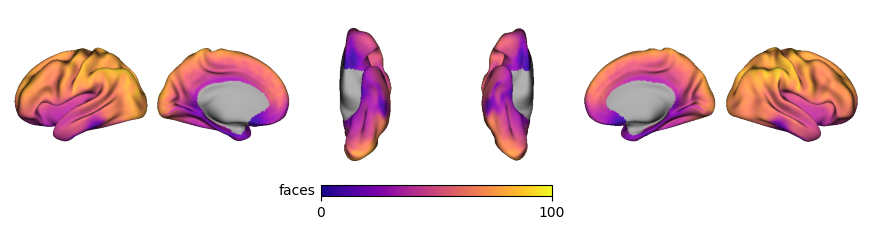

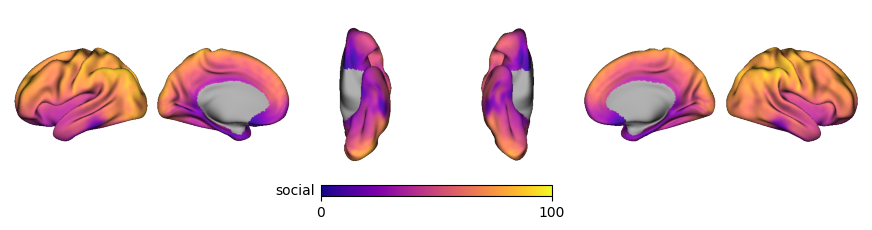

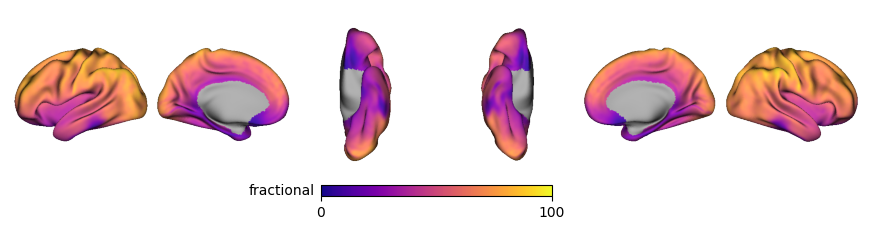

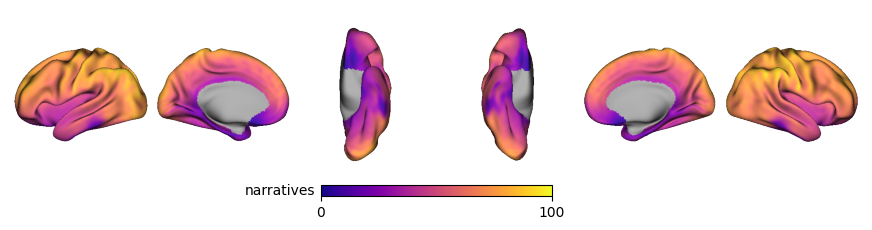

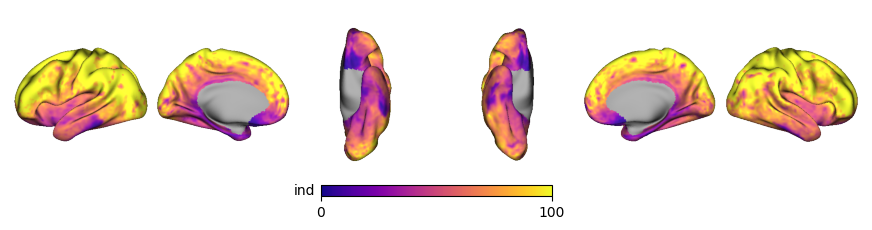

In [89]:
plot_fslr(alignvideo_lh_nonmedial, alignvideo_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100),cbar_label='alignvideo')
plot_fslr(shortvideo_lh_nonmedial, shortvideo_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='shortvideo')
plot_fslr(faces_lh_nonmedial, faces_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='faces')
plot_fslr(social_lh_nonmedial, social_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='social')
plot_fslr(fractional_lh_nonmedial, fractional_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='fractional')
plot_fslr(narratives_lh_nonmedial, narratives_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='narratives')
plot_fslr(ind_lh_nonmedial, ind_rh_nonmedial, density='32k', views=['lateral', 'medial', 'ventral'], surface_type='inflated', cmap_range=(0,100), cbar_label='ind')

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/image/resampling.py:663: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(


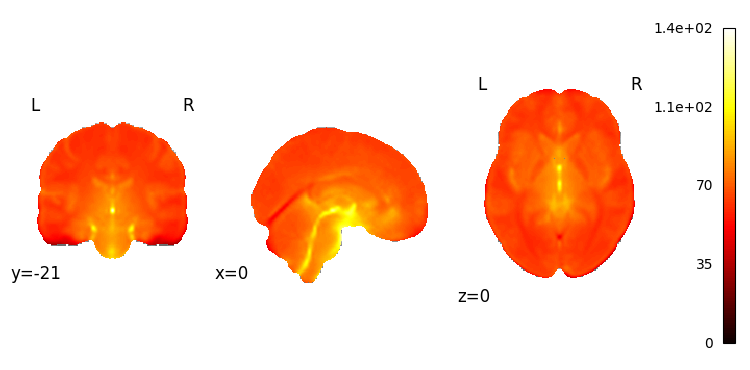

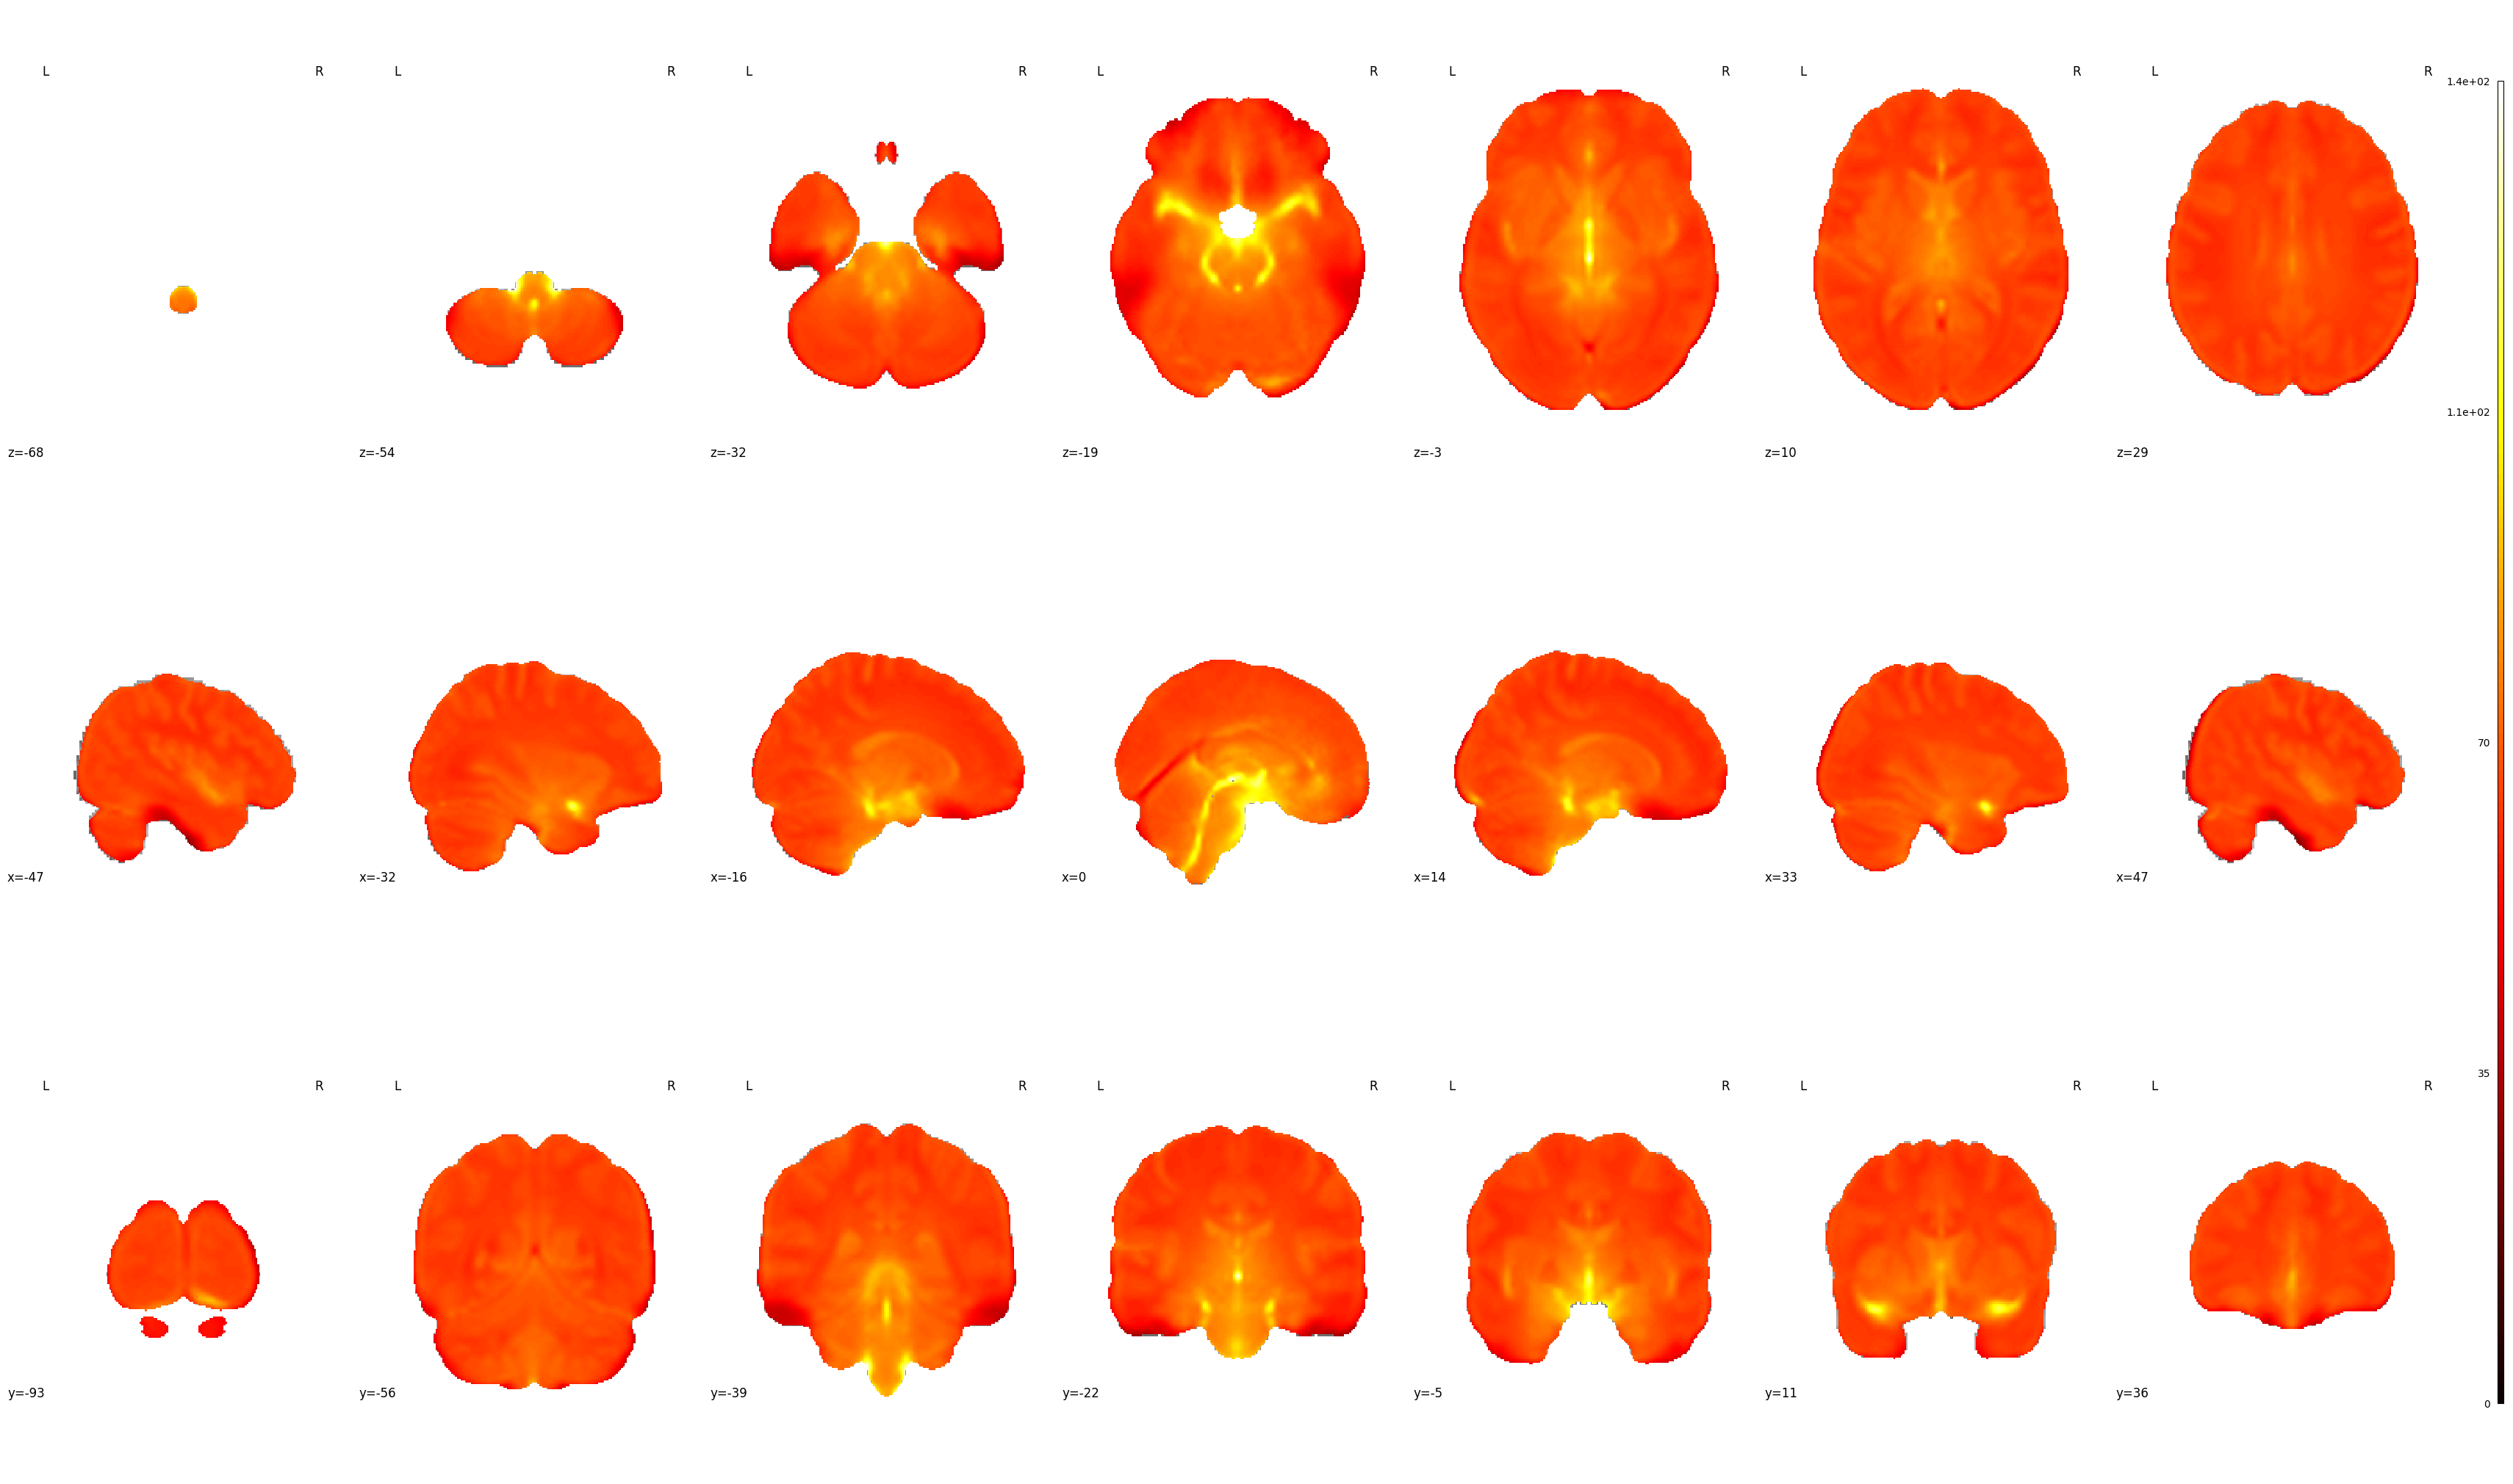

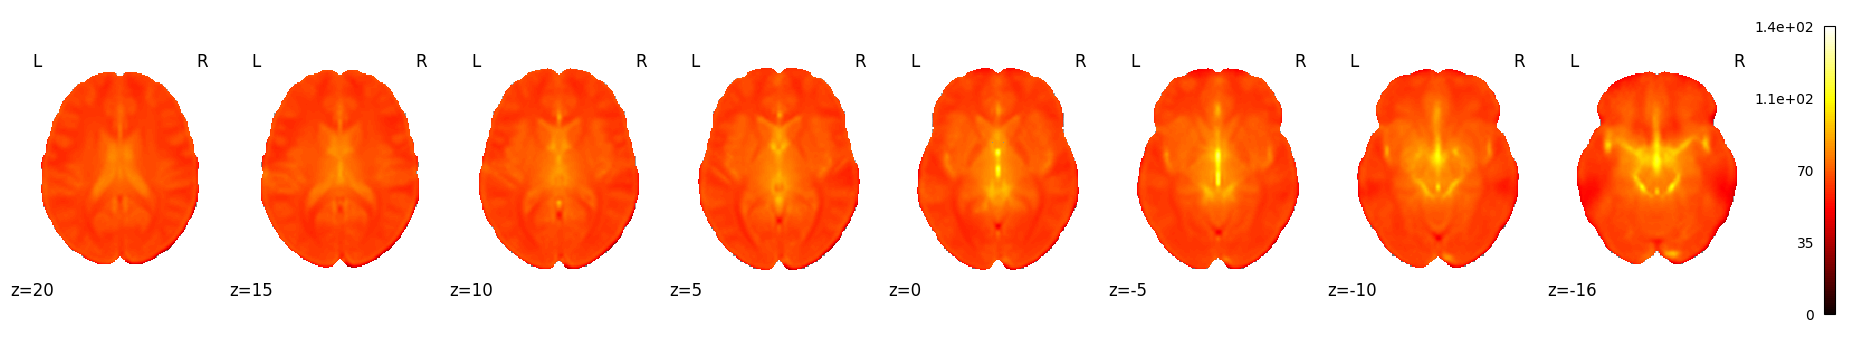

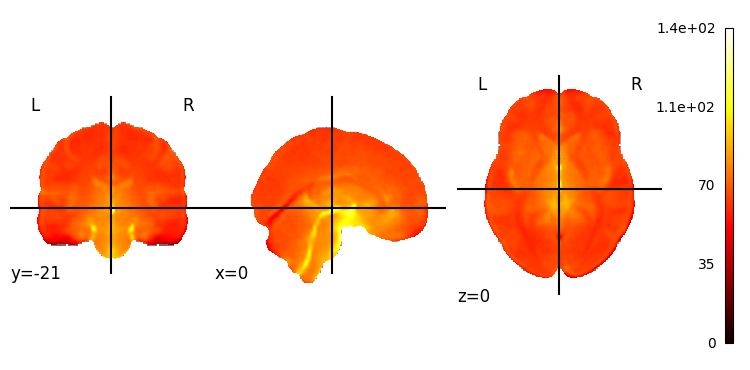

In [6]:
from nilearn.input_data import NiftiMasker
# apply mask
mask = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_icbm.nii'
video = nib.load('/Volumes/fmriprep_qc/tsnr/group_median_tsnr_alignvideo.nii.gz')
# single_nii = nib.load(join(con_dir,'model02-CESO_epoch-stimsimple_stim_P_fdr-0001.nii'))
# nilearn.image.concat_imgs
# nifti_masker = NiftiMasker(mask_img=None,mask_strategy='epi',
#                        standardize=False, memory='nilearn_cache',
#                        memory_level=1)
# fmri_masked = nifti_masker.fit_transform(single_nii)
# masked_brain_image = nifti_masker.inverse_transform(fmri_masked)

############################
#  mni brain mask
from nilearn import datasets, plotting, masking
from nilearn.input_data import NiftiMasker
mni_brain_mask = datasets.load_mni152_brain_mask()
masker = NiftiMasker(mask_img=mni_brain_mask)

data = video.get_fdata()
data[data == 0] = np.nan  # Replace 0 with NaN
stat_map_img = nib.Nifti1Image(data, affine=video.affine)

masked_stat_map = masker.fit_transform(stat_map_img)
masked_stat_map_img = masker.inverse_transform(masked_stat_map)
zmap = t2zmap(masked_stat_map_img, df=97)
############################
# plot stat map

plotting.plot_stat_map(masked_stat_map_img, #join(con_dir,'model02-CESO_epoch-stimsimple_stim_P_fdr-001.nii'), 
                       display_mode='ortho', 
                       draw_cross=False)

plotting.plot_stat_map(masked_stat_map_img, #join(con_dir,'model02-CESO_epoch-stimsimple_stim_P_fdr-001.nii'), 
                       display_mode='mosaic', 
                       draw_cross=False)

z_values = [20, 15, 10, 5, 0, -5, -10, -16]
plotting.plot_stat_map(masked_stat_map_img, #join(con_dir,'model02-CESO_epoch-stimsimple_stim_P_fdr-001.nii'), 
                       display_mode='z', 
                       cut_coords=z_values,
                       draw_cross=False)

display = plotting.plot_stat_map(masked_stat_map_img, 
                       display_mode='ortho')

cbar = display._cbar
cbar.ax.set_aspect(.3)